[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/pulseq_2d_radial_golden_angle.ipynb) [![Download notebook](https://img.shields.io/badge/Download-notebook-blue?logo=jupyter)](path:pulseq_2d_radial_golden_angle.ipynb)

In [1]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebook]

# Reconstruction of 2D golden angle radial data from pulseq sequence
Here we manually do all steps of a direction reconstruction, i.e.
CSM estimation, density compensation, adjoint fourier transform, and coil combination.
See also the example `pulseq_2d_radial_golden_angle_direct_reconstruction.py`
for a more high-level example using the `DirectReconstruction` class.

In [2]:
# Imports
import tempfile

import matplotlib.pyplot as plt
import requests
from mrpro.algorithms.reconstruction import DirectReconstruction
from mrpro.data import KData
from mrpro.data.traj_calculators import KTrajectoryIsmrmrd, KTrajectoryPulseq, KTrajectoryRadial2D

In [3]:
# define zenodo records URL and create a temporary directory and h5-file
zenodo_url = 'https://zenodo.org/records/10854057/files/'
fname = 'pulseq_radial_2D_402spokes_golden_angle_with_traj.h5'
data_file = tempfile.NamedTemporaryFile(mode='wb', delete=False, suffix='.h5')

In [4]:
# Download raw data using requests
response = requests.get(zenodo_url + fname, timeout=30)
data_file.write(response.content)
data_file.flush()

### Image reconstruction using KTrajectoryIsmrmrd
This will use the trajectory that is stored in the ISMRMRD file.

In [5]:
# Read the raw data and the trajectory from ISMRMRD file
kdata = KData.from_file(data_file.name, KTrajectoryIsmrmrd())

# Reconstruct image
direct_reconstruction = DirectReconstruction(kdata)
img_using_ismrmrd_traj = direct_reconstruction(kdata)

### Image reconstruction using KTrajectoryRadial2D
This will calculate the trajectory using the radial 2D trajectory calculator.

In [6]:
# Read raw data and calculate trajectory using KTrajectoryRadial2D
kdata = KData.from_file(data_file.name, KTrajectoryRadial2D())

# Reconstruct image
direct_reconstruction = DirectReconstruction(kdata)
img_using_rad2d_traj = direct_reconstruction(kdata)

### Image reconstruction using KTrajectoryPulseq
This will calculate the trajectory from the pulseq sequence file
using the PyPulseq trajectory calculator. Please note that this method
requires the pulseq sequence file that was used to acquire the data.
The path to the sequence file is provided as an argument to KTrajectoryPulseq.

In [7]:
# download the sequence file from zenodo
zenodo_url = 'https://zenodo.org/records/10868061/files/'
seq_fname = 'pulseq_radial_2D_402spokes_golden_angle.seq'
seq_file = tempfile.NamedTemporaryFile(mode='wb', delete=False, suffix='.seq')
response = requests.get(zenodo_url + seq_fname, timeout=30)
seq_file.write(response.content)
seq_file.flush()

In [8]:
# Read raw data and calculate trajectory using KTrajectoryPulseq
kdata = KData.from_file(data_file.name, KTrajectoryPulseq(seq_path=seq_file.name))

# Reconstruct image
direct_reconstruction = DirectReconstruction(kdata)
img_using_pulseq_traj = direct_reconstruction(kdata)

### Plot the different reconstructed images
Please note: there is currently a mismatch between the actual trajectory
that was used to acquire the data and the trajectory calculated with KTrajectoryRadial2D.
This leads to a deviation between the image reconstructed with KTrajectoryRadial2D
and the other two methods. In the future, we will upload new measurement data with
an updated trajectory and adjust this example accordingly.

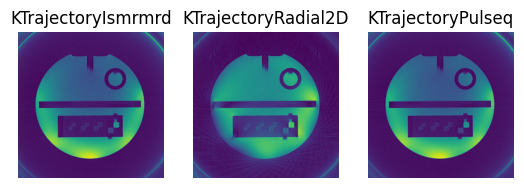

In [9]:
titles = ['KTrajectoryIsmrmrd', 'KTrajectoryRadial2D', 'KTrajectoryPulseq']
plt.subplots(1, len(titles))
for i, img in enumerate([img_using_ismrmrd_traj.rss(), img_using_rad2d_traj.rss(), img_using_pulseq_traj.rss()]):
    plt.subplot(1, len(titles), i + 1)
    plt.imshow(img[0, 0, :, :])
    plt.title(titles[i])
    plt.axis('off')